In [1]:
# reload magic
%load_ext autoreload

In [2]:
import numpy as np
from mldec.utils.bit_tools import binarr
import math
from mldec.datasets import toy_problem_data

In [52]:
6//4

1

In [ ]:
p1 = 0.1
p2 = 0.07

def compute_pr_unimportant_examples(n, p1, p2):
    # unimportant means good but not important
    # this is just for verification, all unimportant + important + bad examples should sum to 1
    all_bitstrings = binarr(n)
    config = {'p1': p1, 'p2': p2}
    probs = toy_problem_data.noise_model(all_bitstrings, n, config, numpy=True)
    idx_sorted = np.argsort(probs)
    halfidx = 2**(n-1)

    out = probs[idx_sorted][halfidx:][::-1]
    sorted_all = all_bitstrings[idx_sorted][halfidx:][::-1]
    # only keep sorted_all that have less than n//2 set bits
    idx_keep = np.where(sorted_all.sum(axis=1) < n//2)
    kept = sorted_all[idx_keep]
    kept_probs = out[idx_keep]
    # for (b, x) in zip(kept, kept_probs):
    #     print(b, x)
    return kept_probs.sum()


def compute_pr_important_examples(n, p1, p2):
    # all important examples have exactly n//2 set bits
    assert n % 2 == 0
    tot = 0
    half_n = n//2
    # This loop _just_ counts errors with exactly n//2 set bits
    for i in range(0, n//4 + 1): # i is the set bits on the LHS, this will only go up to n//4
        temp = math.comb(half_n, i) ** 2 * p2**i * (1-p2)**(half_n - i) * p1**(half_n-i) * (1-p1)**i
        # i is the number of set bits in the first half (prob=p1), and there are n//2-i set bits in the second half (prob=p2)
        temp = math.comb(half_n, i) ** 2 * p2**i * (1-p2)**(half_n - i) * p1**(half_n-i) * (1-p1)**i
        if i == n//4 and n % 4 == 0:
            temp /= 2
        tot += temp
    # the final probability 
    return tot/2


def compute_pr_bad_examples(n, p1, p2):

    assert n % 2 == 0
    tot = 0
    half_n = n//2
    # start by computing the weight n//2 bad examples: This loop _just_ counts errors with exactly n//2 set bits
    for i in range(0, n//4 + 1): # i is the set bits on the LHS, this will only go up to n//4
        temp = math.comb(half_n, i) ** 2 * p1**i * (1-p1)**(half_n - i) * p2**(half_n-i) * (1-p2)**i
        # i is the number of set bits in the first half (prob=p1), and there are n//2-i set bits in the second half (prob=p2)
        temp = math.comb(half_n, i) ** 2 * p1**i * (1-p1)**(half_n - i) * p2**(half_n-i) * (1-p2)**i
        if i == n//4 and n % 4 == 0:
            temp /= 2
        tot += temp
    
    # then, add up all weight > n//2 examples
    # all of these are fair game
    for w in range(n//2+1, n+1):
        # compute all pairs of integers that sum to w, with neither greater than n//2
        for i in range(max(0, w - n//2), min(w, n//2)+1):
            # again, i is the set bits on the LHS, so there are w-i set bits on the RHS
            pr = math.comb(n//2, i) * math.comb(n//2, w-i) * p1**i * (1-p1)**(n//2 - i) * p2**(w-i) * (1-p2)**(n//2 - (w-i))
            tot += pr
    return tot

def compute_pr_bad_examples_v2(n, p1, p2):
    # this is the brute force method and is slow
    all_bitstrings = binarr(n)
    config = {'p1': p1, 'p2': p2}
    probs = toy_problem_data.noise_model(all_bitstrings, n, config, numpy=True)
    idx_sorted = np.argsort(probs)
    halfidx = 2**(n-1)
    # out = probs[idx_sorted][:halfidx][::-1]
    # sorted_all = all_bitstrings[idx_sorted][:halfidx][::-1]
    # for (b, x) in zip(sorted_all, out):
    #     print(b, x)
    return probs[idx_sorted][:halfidx].sum()


In [ ]:
n = 8
for w in range(n//2+1, n+1):
    for i in range(max(0, w - n//2), min(w, n//2)+1):
        print(w, {i, w-i)
    print()

5 1 4
5 2 3
5 3 2
5 4 1

6 2 4
6 3 3
6 4 2

7 3 4
7 4 3

8 4 4



In [65]:
def bitflips_upper_limit_v1(p1, p2):
    return np.log2( (1-p1)/p1) / (np.log2(p1/p2) *(1-p2)/(1-p1) ) 
p1 = 0.1
p2 = 0.6 * p1
print(bitflips_upper_limit_v1(p1, p2))

4.118285303783854


In [70]:
alpha = .4
true_p1 = 0.1
true_p2 = alpha * true_p1
n = 20
div = []
diff = []
pr_importants = []
pr_bads = []
x = np.linspace(0.01, 0.45, 100)
for p1 in x:
    p2 = p1 * alpha
    pr_important = compute_pr_important_examples(n, p1, p2)
    pr_bad = compute_pr_bad_examples(n, p1, p2)
    frac = pr_important / pr_bad
    difference = pr_important - pr_bad
    # print(pr_important, pr_bad, frac, difference)
    div.append(frac)
    diff.append(difference)
    pr_importants.append(pr_important)
    pr_bads.append(pr_bad)
    

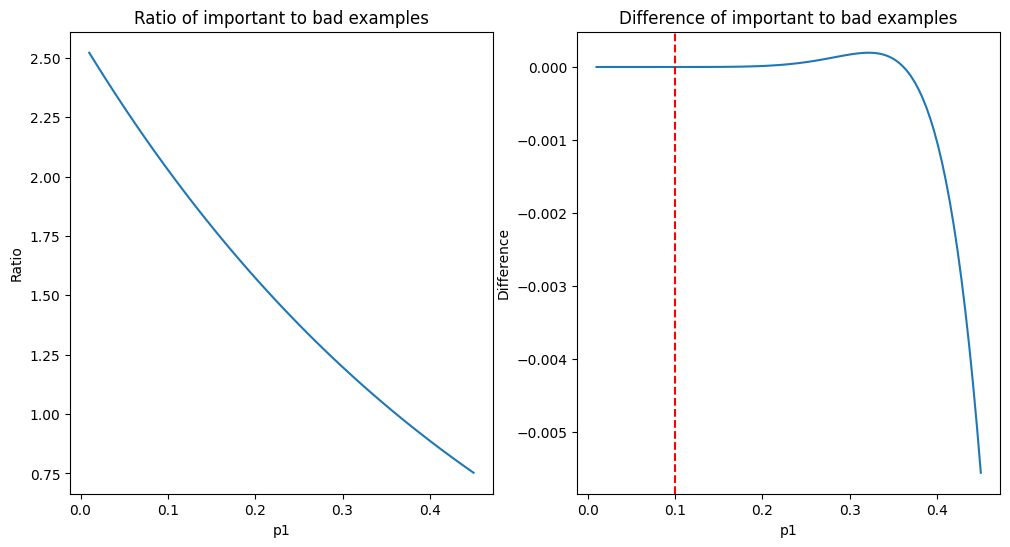

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(x, div)
ax[0].set_title('Ratio of important to bad examples')
ax[0].set_xlabel('p1')
ax[0].set_ylabel('Ratio')
ax[1].plot(x, diff)
ax[1].set_title('Difference of important to bad examples')
ax[1].set_xlabel('p1')
ax[1].set_ylabel('Difference')
ax[1].axvline(true_p1, color='r', linestyle='--')

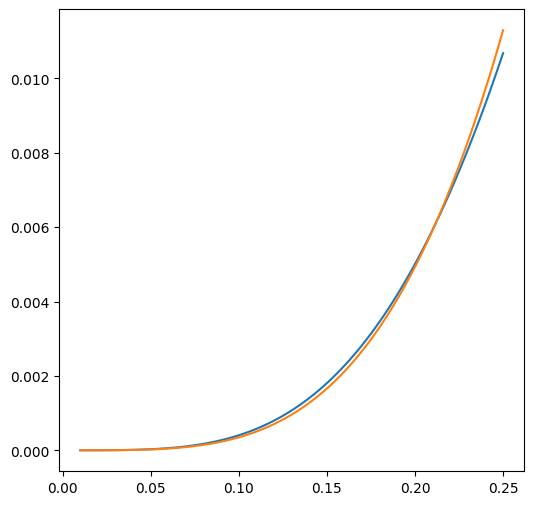

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x, pr_importants)
ax.plot(x, pr_bads)

In [75]:
for n in [6, 8, 10, 12]:
    print(f"n={n}")
    a = compute_pr_important_examples(n, p1, p2)
    b = compute_pr_bad_examples(n, p1, p2)
    c = compute_pr_unimportant_examples(n, p1, p2)
    print(a + b + c)

n=6
1.0
n=8
1.0
n=10
1.0000000000000002
n=12
1.0000000000000002


In [76]:
n = 8
compute_pr_important_examples(n, p1, p2)

0.0015034989150000005

In [52]:
0.0003691170000000001 * 9

0.0033220530000000006

In [29]:
n = 6
halfidx = 2**(n-1)
a = binarr(n)[halfidx: (halfidx + math.comb(n, n//2)//2)]
b = binarr(n)[(halfidx - math.comb(n, n//2)//2): halfidx]
print(len(a))
print(len(b))
for aa,  bb in zip(a, reversed(b)):
    assert np.allclose(aa ^ bb, 1)
    print(aa, bb)

10
10
[1 0 0 0 1 1] [0 1 1 1 0 0]
[1 0 0 1 0 1] [0 1 1 0 1 0]
[1 0 0 1 1 0] [0 1 1 0 0 1]
[1 0 1 0 0 1] [0 1 0 1 1 0]
[1 0 1 0 1 0] [0 1 0 1 0 1]
[1 0 1 1 0 0] [0 1 0 0 1 1]
[1 1 0 0 0 1] [0 0 1 1 1 0]
[1 1 0 0 1 0] [0 0 1 1 0 1]
[1 1 0 1 0 0] [0 0 1 0 1 1]
[1 1 1 0 0 0] [0 0 0 1 1 1]


In [ ]:
binarr(n)[n//2:]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 1, 1],
       [1, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0],
 

In [3]:
# DATASET PARAMETERS
experiment_name = 'repetition_code_v1'

In [ ]:
# Make the repetition code dataset where the first half and last half of bits have different error rates

# tl;dr: make sure the number of bits is less than twice the number printed below.

# goodness check: for the v1 noise model, as long as the number of bitflips
# is less than this limit, then the weight-ordering of bitstrings matches 
# the likelihood ordering. In other words, if you generate all strings with num_bitflips
# k > lim, at least one weight-k bitstring will have lower prob. than some length-(k+1) bitstring
# ASSUMING k < n/2. The violation occurs when all k bitflips happen on the last n/2 bits, and
# k+1 bitflips happen in the first n/2 bits. if k >= n/2, then we are fine.

def bitflips_upper_limit_v1(p1, p2):
    return np.log2( (1-p1)/p1) / (np.log2(p1/p2) *(1-p2)/(1-p1) ) 

print(bitflips_upper_limit_v1(p1, p2))

5.961580428619441


In [ ]:
def repetition_pcm(n):
    out = []
    for i in range(n-1):
        out.append([0]*i + [1, 1] + [0]*(n-i-2))
    return np.array(out, dtype=np.uint8)


def sample_bitstring_v1(n, p1, p2, n_data):
    """Sample bitstrings from the biased bitflip model v1.
    
    Args:
        n: number of bits
        p1, p2: bitflip probabilities for the first and second half of the bits
        n_data: number of samples to generate
    
    Returns:
        (n_data, n) array of bitstrings
    """
    assert n % 2 == 0
    bitstrings = np.random.rand(n_data, n) < np.concatenate([p1*np.ones(n//2), p2*np.ones(n//2)])
    return bitstrings

def bitstring_prob_v1(s, n, p1, p2, permute=None):
    """Create a noise model where the first n//2 bits have prob. p1 of flipping, the last n//2 have prob. p2.
    
    ARgs:
        s: (n_data, n) array of bitstrings.
    Warning: if the difference in bias is too much, the weight-ordering of bitstrings 
     is no longer the same as likelihood ordering. make sure to check the bitflips_upper_limit_v1
    """
    if permute is not None:
        s = s[:,permute]
    p_first = np.prod(p1*s[:,:n//2] +(1-p1)*(1-s[:,:n//2]), axis=1)
    p_second = np.prod(p2*s[:,n//2:] + (1-p2)*(1-s[:,n//2:]), axis=1)
    return np.multiply(p_first, p_second)

def calculator(p1, p2):
    num = p1 ** 2 * (1-p2)**2
    denom = p2 ** 2 * (1-p1)**2
    return num / denom

calculator(0.1, 0.07)

In [14]:
# simulation parameters
n = 8
p1 = 0.1
p2 = 0.07
p1txt = str(p1).replace('.', '')
p2txt = str(p2).replace('.', '')
n_train_vals = np.logspace(10, 17, 9, base=2).astype(int)
n_train_vals = [10000]

In [ ]:

for n_train in n_train_vals:
    dirname = f'n{n}_N{n_train}_p1{p1txt}_p2{p2txt}'
    path = os.path.join(experiment_name, dirname)
    # Check if the data directory exists, if not create it
    if not os.path.exists(path):
        os.makedirs(path)

    Y_train = sample_bitstring_v1(n, p1, p2, n_train).astype(int)
    X_train = (Y_train @ repetition_pcm(n).T % 2).astype(int)
    np.save(f"{path}/X_train.npy", X_train)
    np.save(f"{path}/Y_train.npy", Y_train)

    Y_test = bit_tools.binarr(n)
    X_test = (Y_test @ repetition_pcm(n).T % 2).astype(int)
    weights_test = bitstring_prob_v1(Y_test, n, p1, p2)
    np.save(f"{path}/X_test.npy", X_test)
    np.save(f"{path}/Y_test.npy", Y_test)
    np.save(f"{path}/weights.npy", weights_test)

    # train_path = f"{path}/train.pkl"
    # val_path = f"{path}/test.pkl"
    # save_numpy_as_dict(X_train, train_path)
    # save_numpy_as_dict(Y_train, val_path)


### Grokking dataset

This dataset will contain only good examples, and about 90% of the necessary good examples. Since we plan to train until it learns optimal decoding, we won't weight the data and just provide a list of bitstrings

In [15]:
# The dataset has all bitstrings of <weight 4, and only ~half of the "good" bitstrings that have exactly weight 4
#  (where good bitstrings are themselves the bitstrings that are more likely than their logical negation)
wt_4_bitstrings = []
Y_train = []
for b in bit_tools.binarr(8):
    """For n = 8"""
    tot_count = 8
    if sum(b) < 4:
        Y_train.append(b)
    elif sum(b) > 4:
        break
    elif sum(b) == 4:
        if sum(b[:4]) == 3:
            wt_4_bitstrings.append(b)
        elif sum(b[:4]) == 4:
            Y_train.append(b)
# shuffle the weight 4 bitstrings
np.random.shuffle(wt_4_bitstrings)
# select just 8 of them to add to Y_train
Y_train += wt_4_bitstrings[:8]
Y_train = np.array(Y_train)
X_train = (Y_train @ repetition_pcm(8).T % 2).astype(int)
N = len(Y_train)
dirname = f'grok_n{n}_N{N}_p1{p1txt}_p2{p2txt}'
path = os.path.join(experiment_name, dirname)
if not os.path.exists(path):
    os.makedirs(path)
np.save(f"{path}/X_train.npy", X_train)
np.save(f"{path}/Y_train.npy", Y_train)

Y_test = bit_tools.binarr(n)
X_test = (Y_test @ repetition_pcm(n).T % 2).astype(int)
weights_test = bitstring_prob_v1(Y_test, n, p1, p2)
np.save(f"{path}/X_test.npy", X_test)
np.save(f"{path}/Y_test.npy", Y_test)
np.save(f"{path}/weights.npy", weights_test)